In [33]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy as cart

from xmitgcm import open_mdsdataset
import xmitgcm
import ecco_v4_py as ecco
import pandas as pd

from netCDF4 import Dataset

from analysis_package import plotting_functions
from analysis_package import open_datasets
from analysis_package import integrate_on_density_surfaces
from analysis_package import derive_potential_density_values_TEST

from importlib import reload

# reload modules during prototyping...
plotting_functions = reload(plotting_functions)
open_datasets = reload(open_datasets)
derive_potential_density_values_TEST = reload(derive_potential_density_values_TEST)

"""
import sys
sys.path.append('/Users/Tatsu1/ECCOv4-py/ECCOv4-py/')
import ecco_v4_py_1 as ecco
"""
import os


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [17]:
grid_path = "./ecco_grid/ECCOv4r3_grid.nc"
grid = xr.open_dataset(grid_path)
GM_PSIX_var = "GM_PsiX"
GM_PSIY_var = "GM_PsiY"
tile_data_dir = "./nctiles_monthly/"

In [18]:
time_slice = np.arange(0,12)

Loaded GM_PsiX over time slice  

Loaded GM_PsiY over time slice  



In [36]:
GM_PSIX_var = "GM_PsiX"
GM_PSIY_var = "GM_PsiY"

GM_PSIX_ds_raw = open_datasets.open_combine_raw_ECCO_tile_files(tile_data_dir, 
                                                                GM_PSIX_var, 
                                                                time_slice)
GM_PSIY_ds_raw = open_datasets.open_combine_raw_ECCO_tile_files(tile_data_dir, 
                                                                GM_PSIY_var, 
                                                                time_slice)
GM_PSIX_ds_raw["tile"] = tiles
GM_PSIY_ds_raw["tile"] = tiles
print(GM_PSIX_ds_raw)
GM_PSIX_ds_raw = GM_PSIX_ds_raw.drop("lon").drop("lat")
GM_PSIY_ds_raw = GM_PSIY_ds_raw.drop("lon").drop("lat")
GM_PSIX_ds_raw = GM_PSIX_ds_raw.set_coords(["tile"]).drop("land").drop("area").drop("thic")
GM_PSIY_ds_raw = GM_PSIY_ds_raw.set_coords(["tile"]).drop("land").drop("area").drop("thic")
# do some post-processing..
GM_PSIX_ds_raw = GM_PSIX_ds_raw.assign_coords(k=np.arange(0,50),j=np.arange(0,90),i=np.arange(0,90))
GM_PSIY_ds_raw = GM_PSIY_ds_raw.assign_coords(k=np.arange(0,50),j=np.arange(0,90),i=np.arange(0,90))

# trim datasets if final nan padding value is present.. otherwise this won't change anything
#GM_PSIX_ds_raw = GM_PSIX_ds_raw.isel(i=slice(0,90),j=slice(0,90),k=slice(0,50))
#GM_PSIY_ds_raw = GM_PSIY_ds_raw.isel(i=slice(0,90),j=slice(0,90),k=slice(0,50))
#GM_PSIX_ds_raw.load()
#GM_PSIY_ds_raw.load()

# add in tile coordinates
tiles = np.arange(0,13)

GM_PSIX_ds_raw = GM_PSIX_ds_raw.set_coords(["tile"]).drop("land").drop("area").drop("thic")

GM_PSIX_ds_raw["GM_PsiX"] = GM_PSIX_ds_raw.GM_PsiX.chunk((13,len(time_slice),50,90,90))
GM_PSIY_ds_raw["GM_PsiY"] = GM_PSIY_ds_raw.GM_PsiY.chunk((13,len(time_slice),50,90,90))

Loaded GM_PsiX over time slice  

Loaded GM_PsiY over time slice  

<xarray.Dataset>
Dimensions:  (i: 90, j: 90, k: 50, tile: 13, time: 12)
Coordinates:
  * time     (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
  * k        (k) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 46.0 47.0 48.0 49.0 50.0
  * j        (j) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 86.0 87.0 88.0 89.0 90.0
  * i        (i) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 86.0 87.0 88.0 89.0 90.0
    dep      (k) float64 10.0 20.0 30.0 40.0 ... 5.244e+03 5.678e+03 6.134e+03
    tim      (time) datetime64[ns] 1992-01-16 1992-02-16 ... 1992-12-16
    lon      (tile, j, i) float64 -115.0 -115.0 -115.0 ... -97.07 -102.9 -109.0
    lat      (tile, j, i) float64 -88.24 -88.38 -88.52 ... -88.03 -88.08 -88.1
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    GM_PsiX  (tile, time, k, j, i) float64 nan nan nan nan ... nan nan nan nan
    timstep  (tile, time) float64 732.0 1.428e+03 ... 8.028e+03 8.772e+03


ValueError: One or more of the specified variables cannot be found in this dataset

In [22]:


bolus_u = GM_PSIX_ds_raw.copy(deep=True)
bolus_v = GM_PSIY_ds_raw.copy(deep=True)
bolus_u = bolus_u.rename({'GM_PsiX':'bolus_uvel'})
bolus_v = bolus_v.rename({'GM_PsiY':'bolus_vvel'})
bolus_u.load()
bolus_v.load()


<xarray.Dataset>
Dimensions:     (i: 90, j: 90, k: 50, tile: 13, time: 12)
Coordinates:
  * time        (time) float64 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
  * k           (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * j           (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i           (i) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
    dep         (k) float64 10.0 20.0 30.0 ... 5.244e+03 5.678e+03 6.134e+03
    tim         (time) datetime64[ns] 1992-01-16 1992-02-16 ... 1992-12-16
  * tile        (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    bolus_vvel  (tile, time, k, j, i) float64 nan nan nan nan ... nan nan nan
    timstep     (tile, time) float64 732.0 1.428e+03 ... 8.028e+03 8.772e+03
Attributes:
    description:    GM_PsiY -- ECCO v4 ocean state estimate, release 3 -- 199...
    A:              :Format      = native grid (nctiles w. 13 tiles)
    B:              :source      = ECCO consortium 

In [23]:
# forward stepping method

for tile in tiles:
    print("started tile " + str(tile))
    GM_PSIX_ds_raw_tile = GM_PSIX_ds_raw.isel(tile=tile).fillna(0)
    GM_PSIY_ds_raw_tile = GM_PSIY_ds_raw.isel(tile=tile).fillna(0)


    for k in range(0,49):
        bolus_u.bolus_uvel[tile,:,k,:,:] = (GM_PSIX_ds_raw_tile.GM_PsiX[:,k+1,:,:] - GM_PSIX_ds_raw_tile.GM_PsiX[:,k,:,:])/((grid.drF[k]+grid.drF[k+1])/2.)
        bolus_v.bolus_vvel[tile,:,k,:,:] = (GM_PSIY_ds_raw_tile.GM_PsiY[:,k+1,:,:] - GM_PSIY_ds_raw_tile.GM_PsiY[:,k,:,:])/((grid.drF[k]+grid.drF[k+1])/2.)
   
    bolus_u.bolus_uvel[tile,:,49,:,:] = (GM_PSIX_ds_raw_tile.GM_PsiX[:,49,:,:]*0 - GM_PSIX_ds_raw_tile.GM_PsiX[:,49,:,:])/(grid.drF[49])
    bolus_v.bolus_vvel[tile,:,49,:,:] = (GM_PSIY_ds_raw_tile.GM_PsiY[:,49,:,:]*0 - GM_PSIY_ds_raw_tile.GM_PsiY[:,49,:,:])/(grid.drF[49])
    
bolus_u = bolus_u.rename({'i':'i_g'})
bolus_v = bolus_v.rename({'j':'j_g'})

for tile in tiles:
    if tile < 9:
        pass
        bolus_u.isel(tile=tile).to_netcdf(tile_data_dir+"BOLUS_UVEL/BOLUS_UVEL.000"+str(tile+1)+".nc")
        bolus_v.isel(tile=tile).to_netcdf(tile_data_dir+"BOLUS_VVEL/BOLUS_VVEL.000"+str(tile+1)+".nc")
    else:
        pass
        bolus_u.isel(tile=tile).to_netcdf(tile_data_dir+"BOLUS_UVEL/BOLUS_UVEL.00"+str(tile+1)+".nc")
        bolus_v.isel(tile=tile).to_netcdf(tile_data_dir+"BOLUS_VVEL/BOLUS_VVEL.00"+str(tile+1)+".nc")

    print("saved tile " + str(tile))



started tile 0
started tile 1
started tile 2
started tile 3
started tile 4
started tile 5
started tile 6
started tile 7
started tile 8
started tile 9
started tile 10
started tile 11
started tile 12
saved tile 0
saved tile 1
saved tile 2
saved tile 3
saved tile 4
saved tile 5
saved tile 6
saved tile 7
saved tile 8
saved tile 9
saved tile 10
saved tile 11
saved tile 12


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

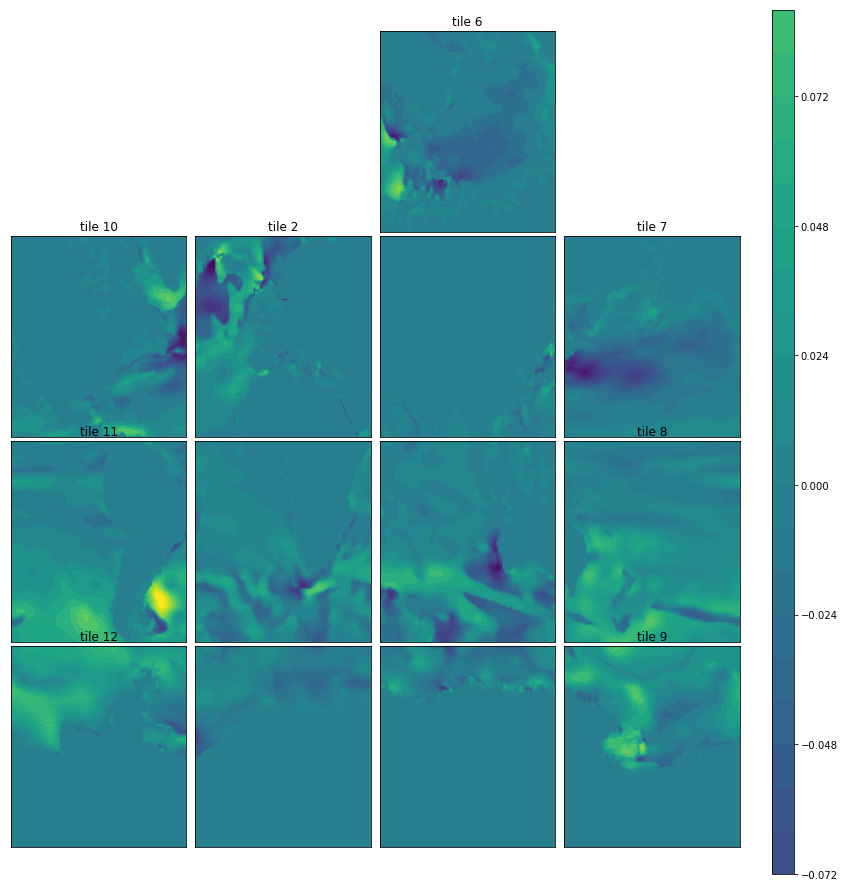

In [32]:
plotting_functions.world_plot(bolus_u.bolus_uvel.isel(time=0).sum(dim="k"))


In [12]:
print(GM_PSIX_ds_raw["GM_PsiX"].isel(time=0,k=0))
print(bolus_u)

<xarray.DataArray 'GM_PsiX' (tile: 13, j: 90, i: 90)>
dask.array<shape=(13, 90, 90), dtype=float64, chunksize=(13, 90, 90)>
Coordinates:
    time     float64 1.0
    k        int64 0
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
    dep      float64 10.0
    tim      datetime64[ns] 1992-01-16
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:  GM Bolus transport stream-function : U component
    units:      m^2/s
<xarray.Dataset>
Dimensions:     (i_g: 90, j: 90, k: 50, tile: 13, time: 12)
Coordinates:
  * time        (time) float64 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
  * k           (k) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * j           (j) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g         (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
    dep         (k) float64 10.

NameError: name 'title' is not defined

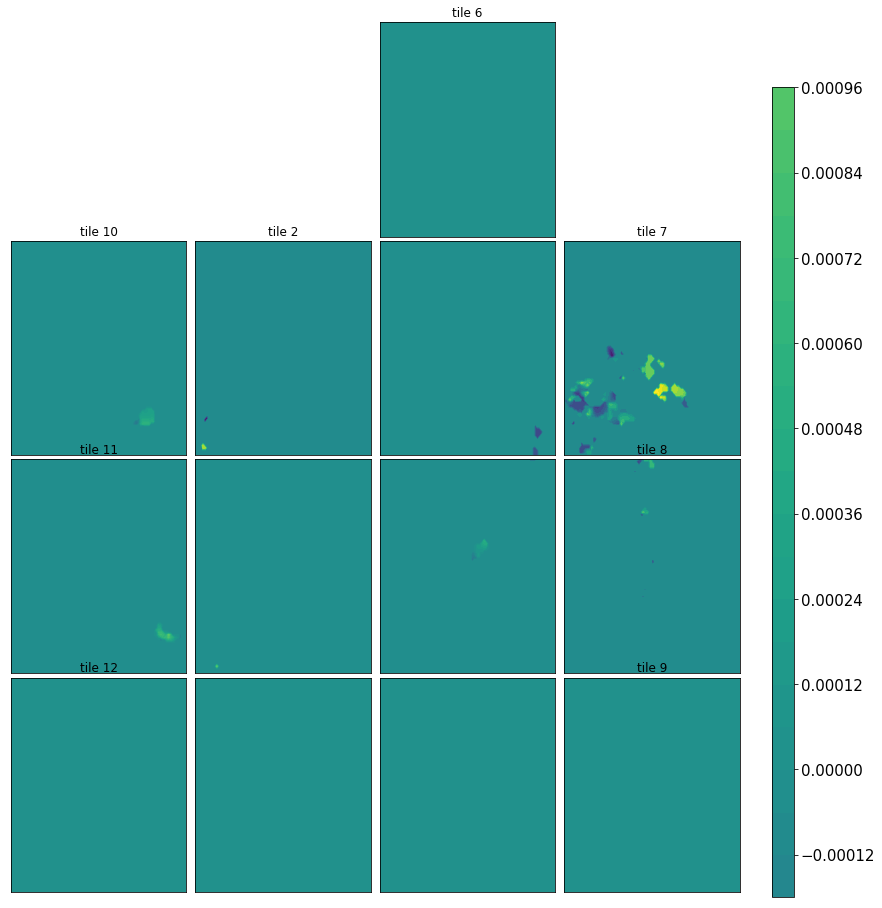

In [13]:
k_level = 49
time_stamp = 8
plotting_functions.world_east_vel_plot(bolus_u["bolus_uvel"].isel(time=time_stamp,k=k_level),bolus_v["bolus_vvel"].isel(time=time_stamp,k=k_level))
plotting_functions.world_north_vel_plot(bolus_u["bolus_uvel"].isel(time=time_stamp,k=k_level),bolus_v["bolus_vvel"].isel(time=time_stamp,k=k_level))




In [ ]:
plotting_functions.world_plot(GM_PSIX_ds_raw["GM_PsiX"].isel(time=0,k=0))

In [ ]:
plotting_functions.world_plot(bolus_u["bolus_uvel"].isel(time=time_stamp,k=k_level))

In [ ]:
k_level=10
print(bolus_u["bolus_uvel"].isel(time=time_stamp,k=k_level).values.max())
print(bolus_v["bolus_vvel"].isel(time=time_stamp,k=k_level).values.max())
print(bolus_u["bolus_uvel"].isel(time=time_stamp,k=k_level).values.min())
print(bolus_v["bolus_vvel"].isel(time=time_stamp,k=k_level).values.min())